<a href="https://colab.research.google.com/github/chang-heekim/Oxford-Pet-Dataset/blob/main/Oxford_Pet_Dataset_Image_Localization_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from glob import glob
from datetime import datetime
import xml.etree.ElementTree as et
from matplotlib.patches import Rectangle

from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
import torch

from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch import nn, optim
from torchsummary import summary
import torch.nn.functional as F
import torchvision.models as models

In [ ]:
IMG_SIZE = 224
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/oxford_pet/annotations/list.txt', skiprows=6, delimiter=' ', header=None)
df.columns = ['file_name', 'id', 'species', 'breed']
df.head()

file_name  id  species  breed
0  Abyssinian_100   1        1      1
1  Abyssinian_101   1        1      1
2  Abyssinian_102   1        1      1
3  Abyssinian_103   1        1      1
4  Abyssinian_104   1        1      1

In [ ]:
image_dir = '/content/drive/MyDrive/dataset/oxford_pet/images/'
bbox_dir = '/content/drive/MyDrive/dataset/oxford_pet/annotations/xmls/'

In [ ]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
n_images = len(image_files)
print(n_images)

7378


In [ ]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
n_bboxes = len(bbox_files)
print(n_bboxes)

3685


In [ ]:
for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    bbox_file = os.path.splitext(image_file)[0] + '.xml'
    bbox_path = os.path.join(bbox_dir, bbox_file)

    image = Image.open(image_path)
    image_mode = image.mode
    if image_mode != 'RGB':
        image = np.asarray(image)
        os.remove(image_path)
        try:
            os.remove(bbox_path)
            
        except FileNotFoundError:
            pass

In [ ]:
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
n_images = len(image_files)
print(n_images)

bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
n_bboxes = len(bbox_files)
print(n_bboxes)

7378
3685


/content/drive/MyDrive/dataset/oxford_pet/annotations/xmls/wheaten_terrier_189.xml
/content/drive/MyDrive/dataset/oxford_pet/images/wheaten_terrier_189.jpg


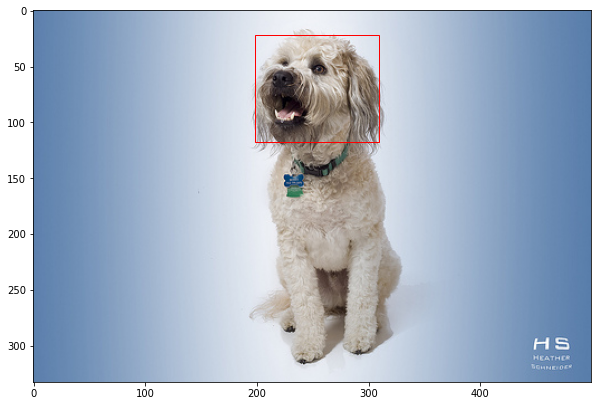

In [ ]:
image_file = image_files[-1000]
image_path = os.path.join(image_dir, image_file)
bbox_file = os.path.splitext(image_file)[0] + '.xml'
bbox_path = os.path.join(bbox_dir, bbox_file)
print(bbox_path)
print(image_path)

image = Image.open(image_path)
image = np.array(image)

tree = et.parse(bbox_path)

xmin = float(tree.find('./object/bndbox/xmin').text)
xmax = float(tree.find('./object/bndbox/xmax').text)
ymin = float(tree.find('./object/bndbox/ymin').text)
ymax = float(tree.find('./object/bndbox/ymax').text)

rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin


rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
plt.figure(figsize=(10, 10))
plt.axes().add_patch(rect)
plt.imshow(image)
plt.show()

In [ ]:
class Oxford_Localization_Dataset(Dataset):
    def __init__(self, bbox_files, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.bbox_files = bbox_files
        
    def __len__(self):
        return len(self.bbox_files)

    def __getitem__(self, idx):
        bbox_file = self.bbox_files[idx]
        bbox_path = os.path.join(bbox_dir, bbox_file)

        tree = et.parse(bbox_path)
        
        width = float(tree.find('./size/width').text)
        height = float(tree.find('./size/height').text)

        xmin = float(tree.find('./object/bndbox/xmin').text)
        xmax = float(tree.find('./object/bndbox/xmax').text)
        ymin = float(tree.find('./object/bndbox/ymin').text)
        ymax = float(tree.find('./object/bndbox/ymax').text)
        
        x = xmin / width 
        y = ymin / height 
        w = (xmax - xmin) / width 
        h = (ymax - ymin) / height

        file_name = os.path.splitext(bbox_file)[0]
        image_file = file_name + '.jpg'
        image_path = os.path.join(image_dir, image_file)

        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            pass

        return image, torch.tensor([x, y, w, h])

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

dataset = Oxford_Localization_Dataset(
    bbox_files=bbox_files, 
    transform=transform, 
)

train_size = 3000
val_size = 685

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_batch_size = 64
val_batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=2)

In [ ]:
dataset[0]

(tensor([[[0.0745, 0.0784, 0.0824,  ..., 0.0235, 0.0196, 0.0235],
          [0.0863, 0.0824, 0.0863,  ..., 0.0235, 0.0196, 0.0196],
          [0.0824, 0.0824, 0.0863,  ..., 0.0235, 0.0196, 0.0196],
          ...,
          [0.0784, 0.0784, 0.0863,  ..., 0.0392, 0.0275, 0.0353],
          [0.0824, 0.0863, 0.0863,  ..., 0.0902, 0.0510, 0.0431],
          [0.0784, 0.0784, 0.0745,  ..., 0.1333, 0.1137, 0.0902]],
 
         [[0.0863, 0.0902, 0.0941,  ..., 0.0235, 0.0235, 0.0275],
          [0.0941, 0.0902, 0.0941,  ..., 0.0235, 0.0235, 0.0235],
          [0.0902, 0.0902, 0.0941,  ..., 0.0235, 0.0196, 0.0196],
          ...,
          [0.0627, 0.0667, 0.0706,  ..., 0.0275, 0.0196, 0.0196],
          [0.0627, 0.0667, 0.0706,  ..., 0.0706, 0.0471, 0.0314],
          [0.0627, 0.0667, 0.0667,  ..., 0.1020, 0.0941, 0.0667]],
 
         [[0.0510, 0.0510, 0.0549,  ..., 0.0118, 0.0078, 0.0039],
          [0.0510, 0.0431, 0.0471,  ..., 0.0118, 0.0078, 0.0078],
          [0.0549, 0.0510, 0.0549,  ...,

In [ ]:
classes = {
    0: 'Dog',
    1: 'Cat'
}

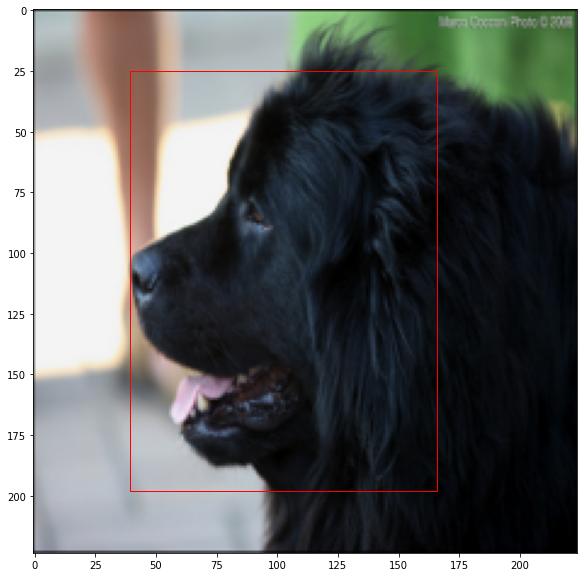

In [ ]:
img, lab = next(iter(train_loader))
image, label = img[2], lab[2]

rect = Rectangle((label[0] * IMG_SIZE, label[1] * IMG_SIZE), label[2] * IMG_SIZE, label[3] * IMG_SIZE, fill=False, color='red')
plt.figure(figsize=(10, 10))
plt.axes().add_patch(rect)
plt.imshow(torch.permute(image, (1, 2, 0)))
plt.show()

In [ ]:
for idx, sample_batch in enumerate(train_loader):
    print(sample_batch[0].shape)
    print(sample_batch[1].shape)
    print()
    break

torch.Size([64, 3, 224, 224])
torch.Size([64, 4])



In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.flatten = nn.Flatten()
        
        self.founder = nn.Sequential(
            nn.Linear(25088 , 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4)
        )

    def forward(self, x):
        out = self.feature_extractor(x)
        out = self.flatten(out)
        
        out = self.founder(out)
        out = torch.sigmoid(out)
        
        return out

In [ ]:
def iou(bbox_preds, bbox_targets):
    xmin = bbox_targets[..., 0:1]
    ymin = bbox_targets[..., 1:2]
    xmax = bbox_targets[..., 2:3] + xmin
    ymax = bbox_targets[..., 3:4] + ymin

    pred_xmin = bbox_preds[..., 0:1]
    pred_ymin = bbox_preds[..., 1:2]
    pred_xmax = bbox_preds[..., 2:3] + pred_xmin
    pred_ymax = bbox_preds[..., 3:4] + pred_ymin

    union_w = torch.max(xmax, pred_xmax) - torch.min(xmin, pred_xmin)
    union_h = torch.max(ymax, pred_ymax) - torch.min(ymin, pred_ymin)
    inter_w = torch.min(xmax, pred_xmax) - torch.max(xmin, pred_xmin)
    inter_h = torch.min(ymax, pred_ymax) - torch.max(ymin, pred_ymin)

    sub1_w = torch.abs(xmax - pred_xmax)
    sub1_h = torch.abs(ymin - pred_ymin)
    sub2_w = torch.abs(xmin - pred_xmin)
    sub2_h = torch.abs(ymax - pred_ymax)

    iou = (inter_w * inter_h) / ((union_w * union_h) - (sub1_w * sub1_h) - (sub2_w * sub2_h))
    return iou

In [ ]:
lr = 1e-2
epochs = 40

mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier = nn.Sequential(
    nn.Linear(1280, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 4),
    nn.Sigmoid()
)

model = mobilenet.to(device)
model_name = type(model).__name__
summary(model, (3, 224, 224))

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=lr)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
# With some modifications, source is from https://github.com/Bjarten/early-stopping-pytorch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.ckpt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.ckpt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        filename = self.path.split('/')[-1]
        save_dir = os.path.dirname(self.path)
        torch.save(model, os.path.join(save_dir, f"val_loss-{val_loss}-{filename}"))
        self.val_loss_min = val_loss

In [ ]:
def train(epoch, model, train_loader, loss_fn, optimizer):
    print(f' Epoch: [{epoch}/{epochs}] - Train')
    model.train()
    torch.autograd.set_detect_anomaly(True)
    current_loss = 0.0

    for batch_idx, (images, bbox) in enumerate(train_loader):
        images, bbox = images.to(device), bbox.to(device)

        outputs = model(images)

        loss = loss_fn(outputs, bbox)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            train_loss = current_loss / 10
            print(f'Current Step: {batch_idx + 1} \tTrain Loss: {train_loss}')

            current_loss = 0.0

    return train_loss

def validation(epoch, model, val_loader, loss_fn):
    print(f' Epoch: [{epoch}/{epochs}] - Validation')
    with torch.no_grad():
        model.eval()
        val_loss = 0.0

        for val_idx, (val_images, val_bbox) in enumerate(val_loader):

            val_images, val_bbox = val_images.to(device), val_bbox.to(device)

            val_outputs = model(val_images)

            val_loss += loss_fn(val_outputs, val_bbox)

        val_epoch_loss = val_loss / len(val_loader)

    print(f'Validation step: Val Loss: {val_epoch_loss}')

    return val_epoch_loss

In [ ]:
log_dir = f"runs/{datetime.now().isoformat(timespec='seconds')}-{model_name}"
model_path = os.path.join(log_dir, 'models')
os.makedirs(model_path, exist_ok=True)

In [ ]:
train_result = []
val_result = []

early_stopper = EarlyStopping(
    patience=7, verbose=True, path=os.path.join(model_path, "model.ckpt")
)


for epoch in range(1, epochs + 1):
    train_loss = train(epoch, model, train_loader, loss_fn, optimizer)
    val_loss = validation(epoch, model, val_loader, loss_fn)
    
    early_stopper(val_loss, model)
    if early_stopper.early_stop:
        break

    train_result.append(train_loss)
    val_result.append(val_loss)

 Epoch: [1/40] - Train
Current Step: 10 	Train Loss: 0.05793087650090456
Current Step: 20 	Train Loss: 0.026762413419783117
Current Step: 30 	Train Loss: 0.026076524704694747
Current Step: 40 	Train Loss: 0.02368768472224474
 Epoch: [1/40] - Validation
Validation step: Val Loss: 0.038588471710681915
Validation loss decreased (inf --> 0.038588).  Saving model ...
 Epoch: [2/40] - Train
Current Step: 10 	Train Loss: 0.02302890382707119
Current Step: 20 	Train Loss: 0.021634228900074957
Current Step: 30 	Train Loss: 0.022706517949700356
Current Step: 40 	Train Loss: 0.02071862667798996
 Epoch: [2/40] - Validation
Validation step: Val Loss: 0.05062267184257507
EarlyStopping counter: 1 out of 7
 Epoch: [3/40] - Train
Current Step: 10 	Train Loss: 0.021373037621378897
Current Step: 20 	Train Loss: 0.019666910730302335
Current Step: 30 	Train Loss: 0.020145700499415397
Current Step: 40 	Train Loss: 0.01788510996848345
 Epoch: [3/40] - Validation
Validation step: Val Loss: 0.021747304126620293

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


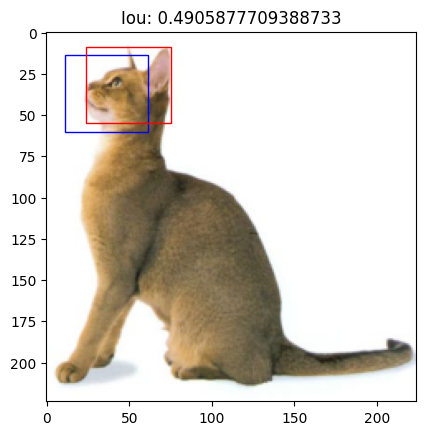

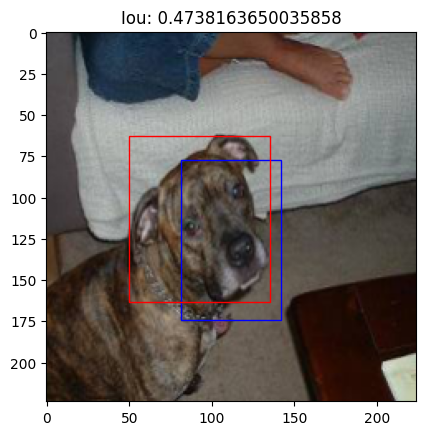

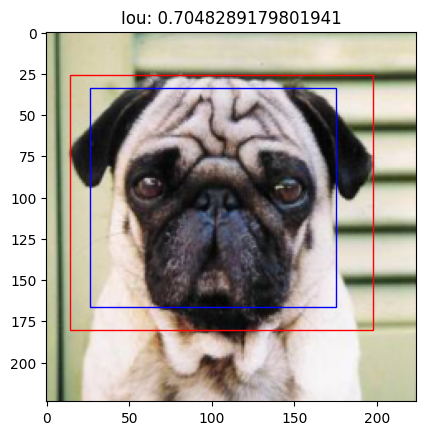

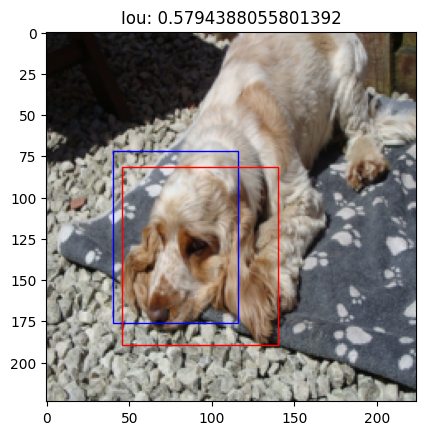

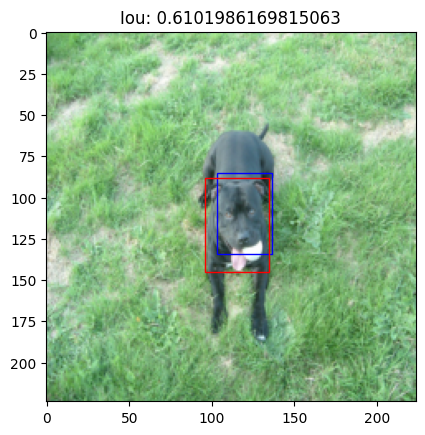

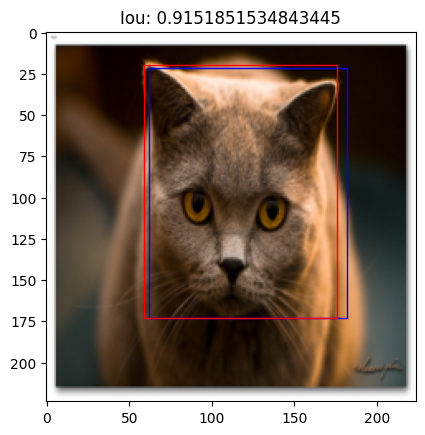

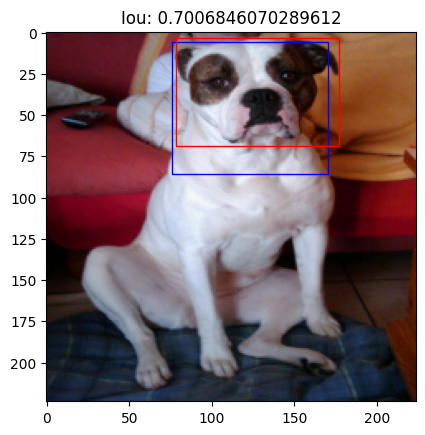

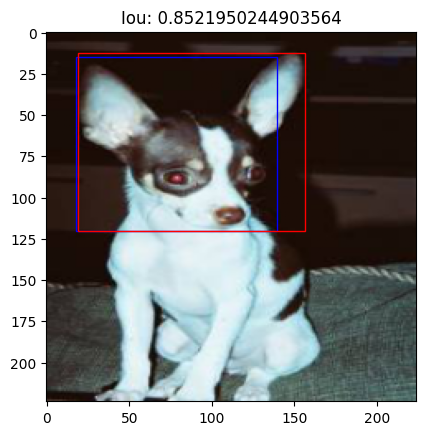

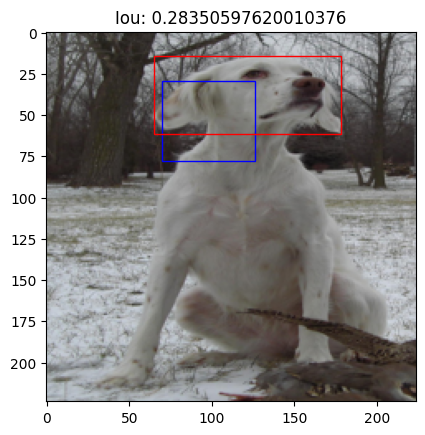

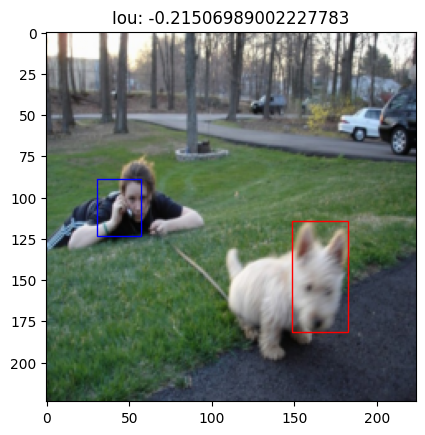

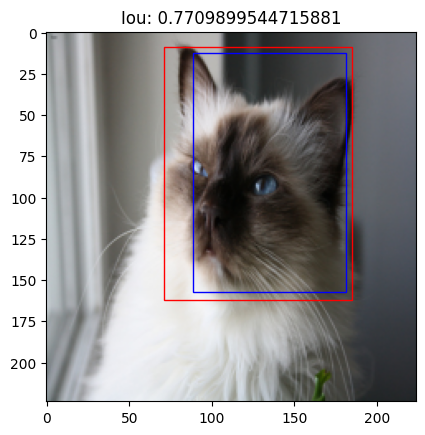

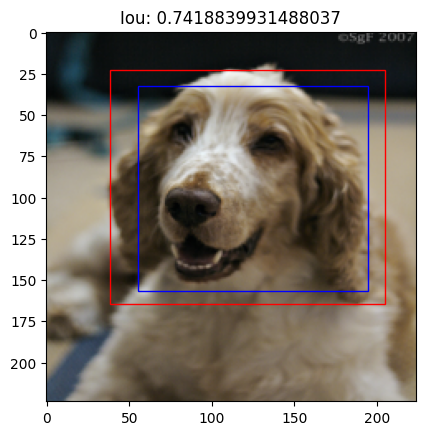

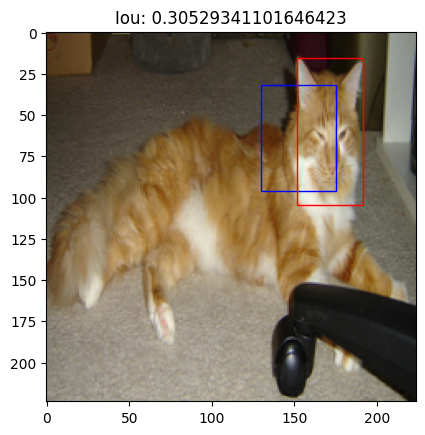

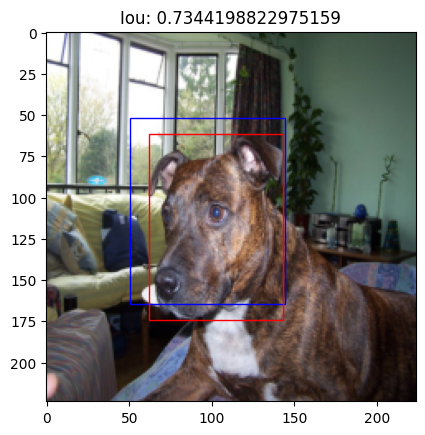

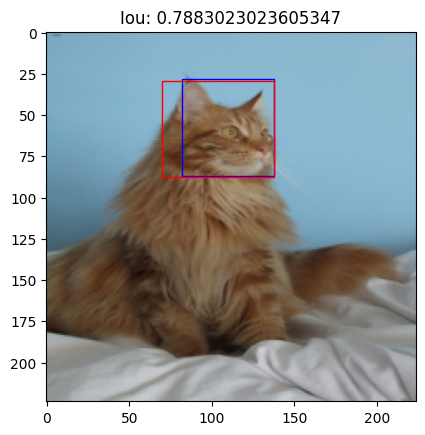

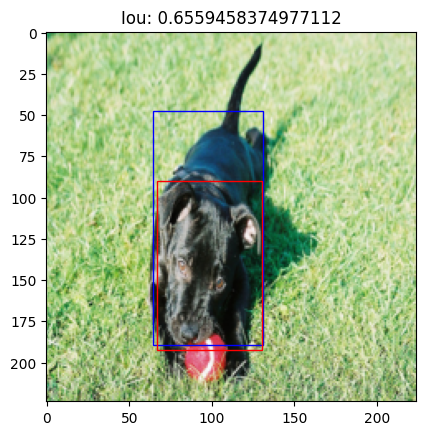

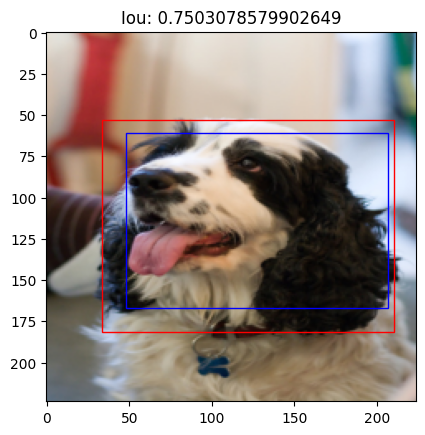

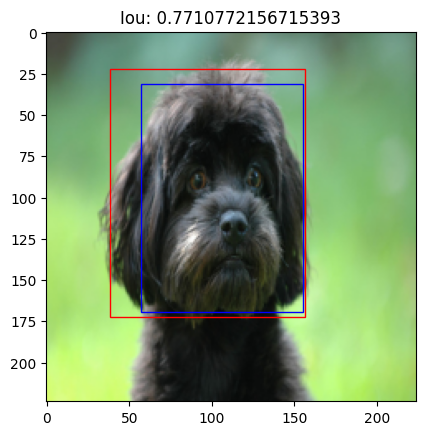

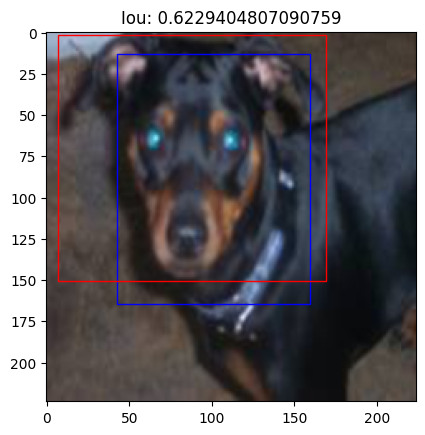

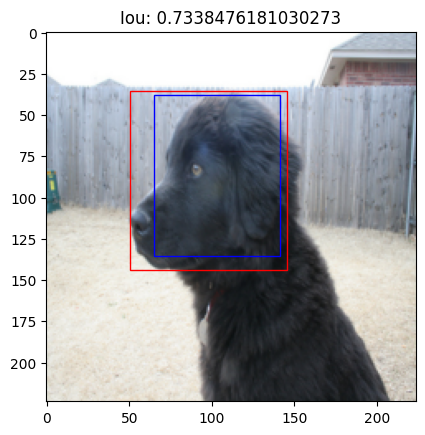

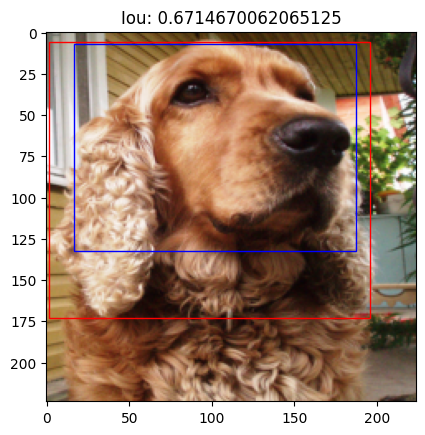

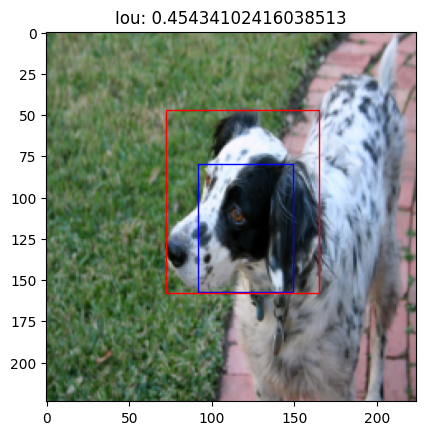

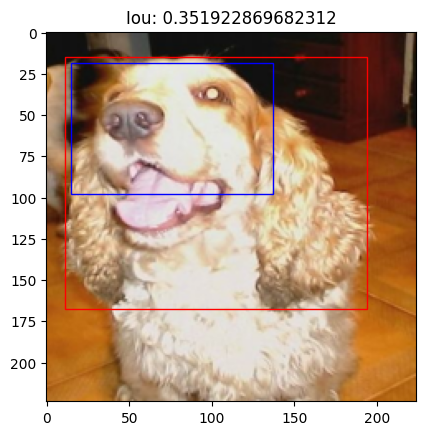

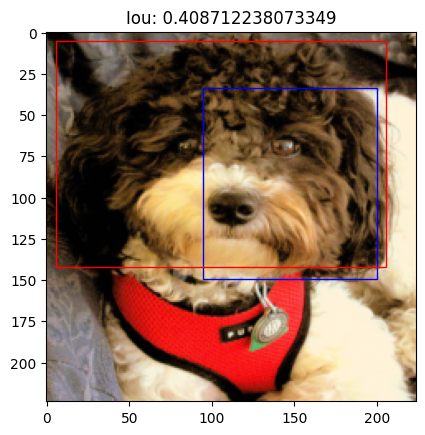

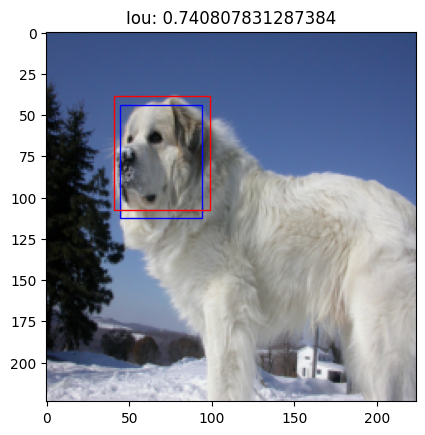

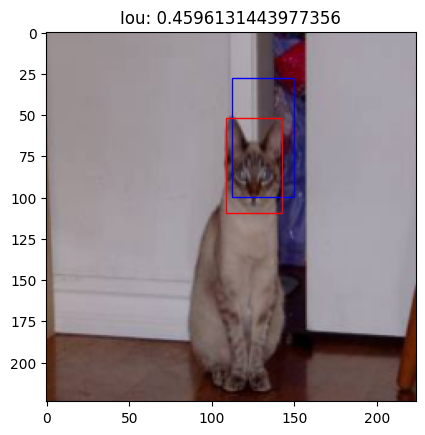

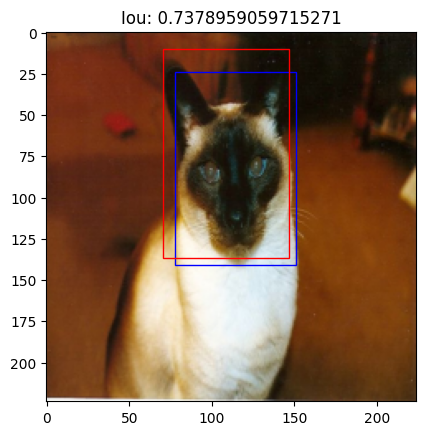

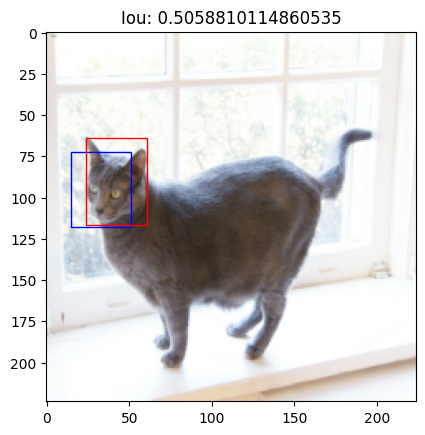

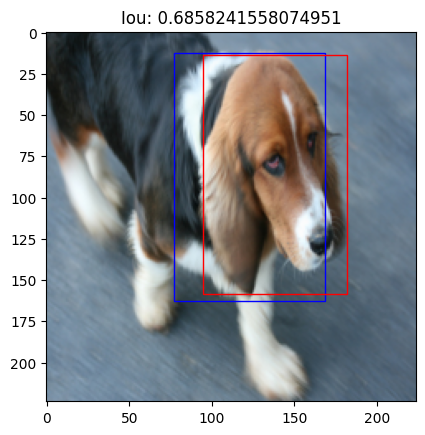

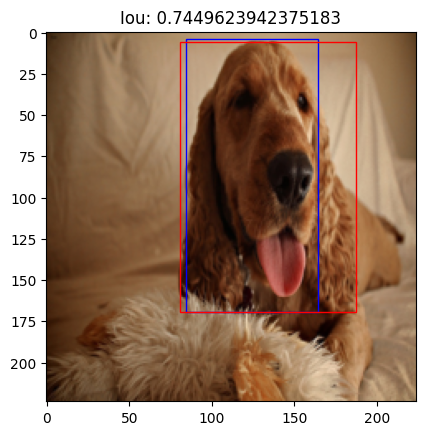

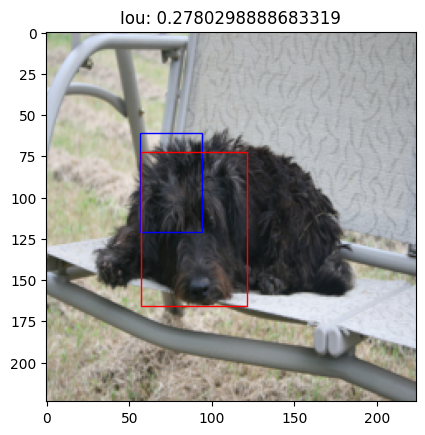

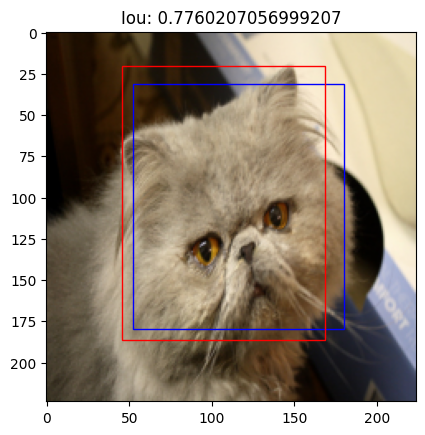

In [ ]:
images, labels = next(iter(val_loader))

model.eval()
preds = model(images.to(device))
plt.style.use('default')
for image, label, pred in zip(images, labels, preds):
    pred_rect = Rectangle((pred[0] * IMG_SIZE, pred[1] * IMG_SIZE), pred[2] * IMG_SIZE, pred[3] * IMG_SIZE, fill=False, color='blue')
    rect = Rectangle((label[0] * IMG_SIZE, label[1] * IMG_SIZE), label[2] * IMG_SIZE, label[3] * IMG_SIZE, fill=False, color='red')
    plt.axes().add_patch(pred_rect)
    plt.axes().add_patch(rect)
    plt.imshow(torch.permute(image, (1, 2, 0)))
    plt.title('Iou: ' + str(iou(pred, label.to(device)).item()))
    plt.show()

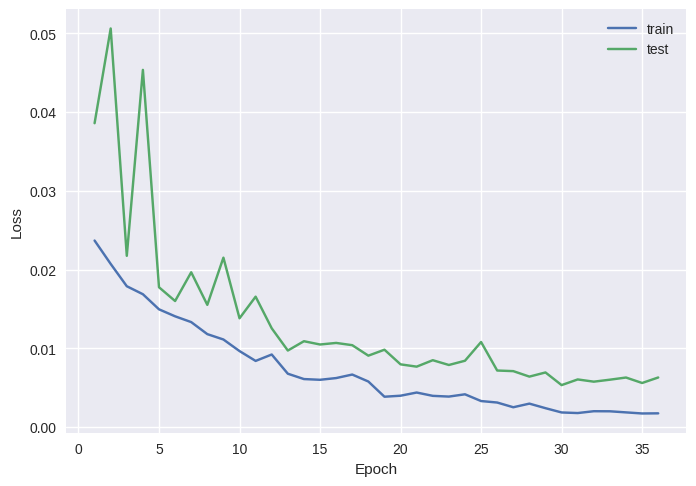

In [ ]:
plt.style.use('seaborn')
plt.plot([i for i in range(1, len(train_result) + 1)], [i for i in train_result])
plt.plot([i for i in range(1, len(val_result) + 1)], [i for i in val_result])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "Val"])
plt.show()